In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import os

import talib as ta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [14]:

# 1. 读取数据
df = pd.read_csv('data/spot/binance/15m/BTC_USDT.csv')

# 选择时间范围
START_DATE = '2023-06-01'
END_DATE = '2025-06-30'
# 确保时间列为datetime类型
df['datetime'] = pd.to_datetime(df['datetime'])
data = df[(df['datetime'] >= START_DATE) & (df['datetime'] <= END_DATE)]
data.set_index('datetime', inplace=True)
data['ret'] = data['close'].pct_change()

data.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\604522289.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ret'] = data['close'].pct_change()


,open,high,low,close,volume,ret
datetime,,,,,,
2023-06-01 00:00:00,27210.36,27350.00,27198.00,27318.11,843.33387,NaN
2023-06-01 00:15:00,27318.11,27338.80,27281.26,27281.27,447.97561,-0.001349
2023-06-01 00:30:00,27281.26,27297.20,27065.84,27111.73,932.19792,-0.006215
2023-06-01 00:45:00,27111.73,27111.73,27023.35,27065.77,549.31703,-0.001695
2023-06-01 01:00:00,27065.76,27145.52,27059.74,27126.40,380.74336,0.002240


In [15]:
missing = df.isnull().sum()
print("Missing values in total dataset:\n", missing)

Missing values in total dataset:
 datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64


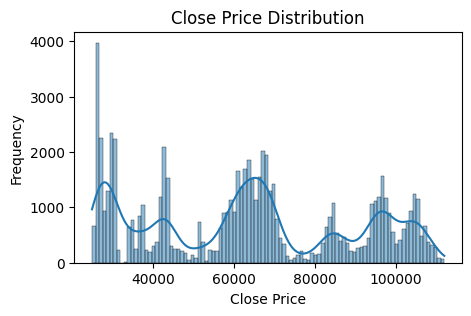

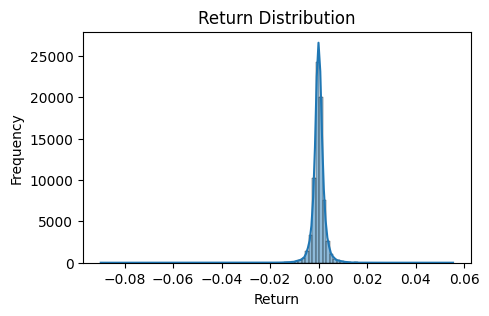

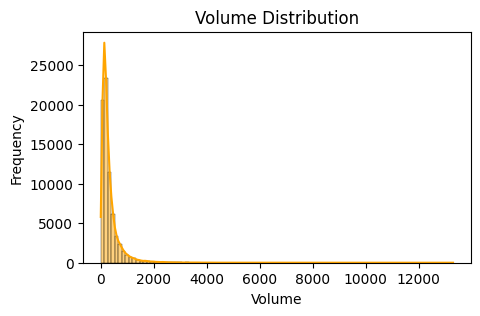

                open           high            low          close  \
count   72961.000000   72961.000000   72961.000000   72961.000000   
mean    63331.129743   63435.674913   63223.563573   63332.241442   
std     25915.526686   25961.765073   25868.985485   25915.720301   
min     24893.100000   24926.790000   24800.000000   24893.090000   
25%     40661.810000   40779.660000   40532.170000   40679.970000   
50%     63464.770000   63582.000000   63343.470000   63465.410000   
75%     85502.030000   85690.020000   85329.270000   85502.170000   
max    111898.740000  111980.000000  111681.810000  111898.740000   

             volume  
count  72961.000000  
mean     340.541351  
std      427.859641  
min        3.985380  
25%      126.941280  
50%      216.317980  
75%      391.761020  
max    13289.889260  


,open,high,low,close,volume,ret
count,72961.000000,72961.000000,72961.000000,72961.000000,72961.000000,72960.000000
mean,63331.129743,63435.674913,63223.563573,63332.241442,340.541351,0.000022
std,25915.526686,25961.765073,25868.985485,25915.720301,427.859641,0.002599
min,24893.100000,24926.790000,24800.000000,24893.090000,3.985380,-0.089797
25%,40661.810000,40779.660000,40532.170000,40679.970000,126.941280,-0.001064
50%,63464.770000,63582.000000,63343.470000,63465.410000,216.317980,0.000009
75%,85502.030000,85690.020000,85329.270000,85502.170000,391.761020,0.001119
max,111898.740000,111980.000000,111681.810000,111898.740000,13289.889260,0.055415


In [16]:
# 2. 数据预处理，做一些初步的数据统计分布描述

# 绘制价格分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['close'], bins=100, kde=True)
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# 绘制收益率分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['ret'], bins=100, kde=True)
plt.title('Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# 绘制成交量分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['volume'], bins=100, kde=True, color='orange')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# 计算并显示主要数值特征的描述性统计
print(data[['open', 'high', 'low', 'close', 'volume']].describe())
data.describe()


In [17]:
# 2. 特征工程（示例：用常见技术指标）
"""
技术指标列表
趋势: EMA (20, 60, 100, 200), MACD (12,26,9; 5,35,5), ADX (14)
动量: RSI (10, 20, 60), %K Stochastic (10, 30, 200)
反转: ROC(RSI) (10, 20, 50)
振幅: ATR (20, 60, 100), Bollinger Bands (20, 2)
成交量: OBV, VWAP
短期动态: MOM (10, 30, 50), PROC (10, 50)
"""

# 用talib计算特征，全部用talib函数

# 用talib计算特征，全部用talib函数
data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
data['ema_100'] = ta.EMA(data['close'], timeperiod=100)
data['ema_200'] = ta.EMA(data['close'], timeperiod=200)

macd_20_60, macdsignal_20_60, macdhist_20_60 = ta.MACD(data['close'], fastperiod=20, slowperiod=60, signalperiod=9)
macd_10_20, macdsignal_10_20, macdhist_10_20 = ta.MACD(data['close'], fastperiod=10, slowperiod=20, signalperiod=5)
data['macd_20_60'] = macd_20_60
data['macd_10_20'] = macd_10_20

data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10)
data['adx_20'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=20)
data['adx_60'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=60)

data['rsi_7'] = ta.RSI(data['close'], timeperiod=7)
data['rsi_20'] = ta.RSI(data['close'], timeperiod=20)
data['rsi_60'] = ta.RSI(data['close'], timeperiod=60)

slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=10, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_30, slowd_30 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=30, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_100, slowd_100 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=100, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['stoch_k_10'] = slowk_10
data['stoch_k_30'] = slowk_30
data['stoch_k_100'] = slowk_100

data['roc_rsi_10'] = ta.ROC(data['rsi_7'], timeperiod=10)
data['roc_rsi_20'] = ta.ROC(data['rsi_7'], timeperiod=20)
data['roc_rsi_50'] = ta.ROC(data['rsi_7'], timeperiod=50)

data['atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20)
data['atr_60'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=60)
data['atr_100'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=100)

# talib没有直接的Bollinger带宽和百分比，需手动计算
upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
data['bb_width'] = upper - lower
data['bb_percent'] = (data['close'] - lower) / (upper - lower)

data['obv'] = ta.OBV(data['close'], data['volume'])

# VWAP简单实现
data['vwap'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()

data['mom_5'] = ta.MOM(data['close'], timeperiod=5)
data['mom_20'] = ta.MOM(data['close'], timeperiod=20)
data['mom_50'] = ta.MOM(data['close'], timeperiod=50)

data['proc_5'] = ta.ROC(data['close'], timeperiod=5)
data['proc_20'] = ta.ROC(data['close'], timeperiod=20)

data['vol_ma_20'] = data['volume'].rolling(window=20).mean()
data['vol_ma_60'] = data['volume'].rolling(window=60).mean()

data.dropna(inplace=True)  # 删除含有NaN的行

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\1919249095.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
C:\Users\hp\AppData\Local\Temp\ipykernel_45368\1919249095.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
C:\Users\hp\AppData\Local\Temp\ipykernel_45368\1919249095.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [18]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ret', 'ema_20', 'ema_60',
       'ema_100', 'ema_200', 'macd_20_60', 'macd_10_20', 'adx_10', 'adx_20',
       'adx_60', 'rsi_7', 'rsi_20', 'rsi_60', 'stoch_k_10', 'stoch_k_30',
       'stoch_k_100', 'roc_rsi_10', 'roc_rsi_20', 'roc_rsi_50', 'atr_20',
       'atr_60', 'atr_100', 'bb_width', 'bb_percent', 'obv', 'vwap', 'mom_5',
       'mom_20', 'mom_50', 'proc_5', 'proc_20', 'vol_ma_20', 'vol_ma_60'],
      dtype='object')

In [19]:
os.makedirs("data/BTC/raw", exist_ok=True)
data.to_csv("data/BTC/raw/values.csv")

In [20]:
TARGET_PERIOD = 5
# T-1 到 T+4 的涨跌为目标
# >0 为正样本，<=0为负样本，符合lightgbm的二分类标记
data['target_ret'] = (data['close'].shift(-TARGET_PERIOD) / data['close']) - 1
data['target'] = 0
data.loc[data['target_ret'] > 0.0015, 'target'] = 1
data.loc[data['target_ret'] < -0.0015, 'target'] = -1

# 删除含有NaN值的行
data.dropna(inplace=True)  

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\3165444956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target_ret'] = (data['close'].shift(-TARGET_PERIOD) / data['close']) - 1
C:\Users\hp\AppData\Local\Temp\ipykernel_45368\3165444956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = 0
C:\Users\hp\AppData\Local\Temp\ipykernel_45368\3165444956.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

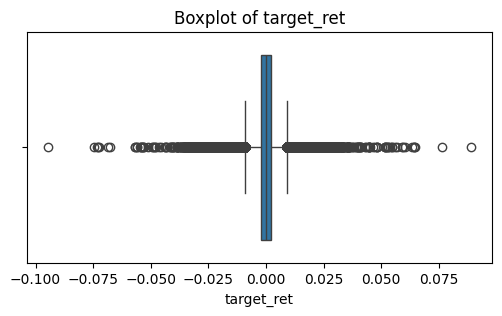

0.00   -0.094528
0.01   -0.016774
0.05   -0.007900
0.10   -0.005135
0.25   -0.002138
0.50    0.000081
0.75    0.002381
0.90    0.005415
0.95    0.008131
0.99    0.017037
1.00    0.088945
Name: target_ret, dtype: float64


In [21]:
# 绘制 target_ret 的箱线图
plt.figure(figsize=(6, 3))
sns.boxplot(x=data['target_ret'])
plt.title('Boxplot of target_ret')
plt.xlabel('target_ret')
plt.show()

# 查看 target_ret 的分位数分布
print(data['target_ret'].quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]))

In [22]:
print(data['target'].value_counts(normalize=True))

target
 0    0.362316
 1    0.330044
-1    0.307641
Name: proportion, dtype: float64


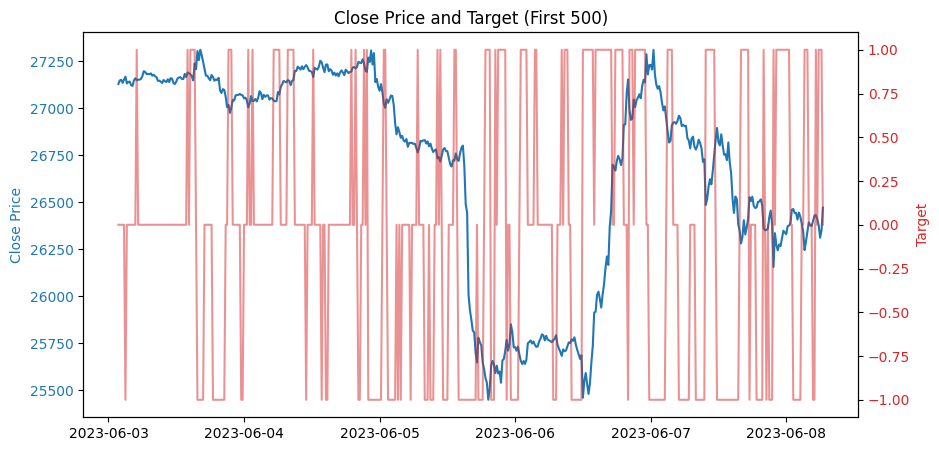

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data['close'][:500], color='tab:blue', label='Close')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(data['target'][:500], color='tab:red', label='Target', alpha=0.5)
ax2.set_ylabel('Target', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Close Price and Target (First 500)')
plt.show()

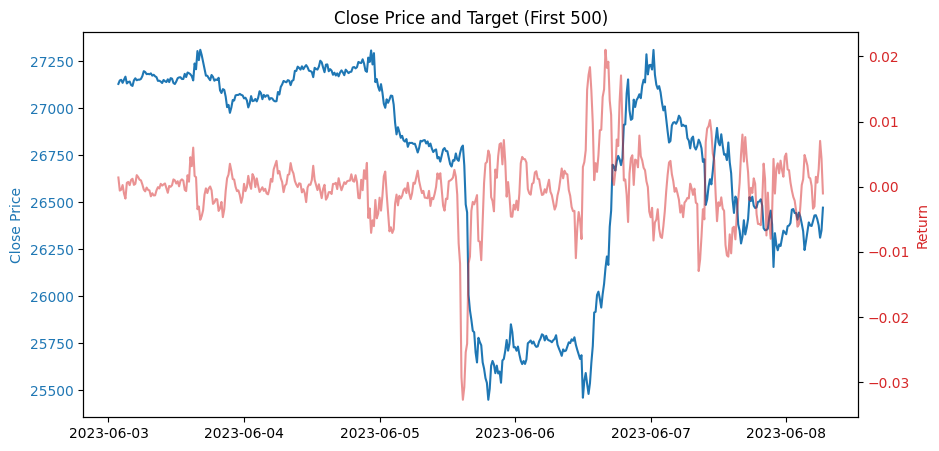

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data['close'][:500], color='tab:blue', label='Close')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(data['target_ret'][:500], color='tab:red', label='Return', alpha=0.5)
ax2.set_ylabel('Return', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Close Price and Target (First 500)')
plt.show()

In [ ]:
# 假设data的index是UTC时区的datetime
data.index = data.index.tz_localize('UTC').tz_convert('Asia/Shanghai')

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\1417857758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['half_hour'] = data.index.hour.astype(str).str.zfill(2) + ':' + (data.index.minute // 30 * 30).astype(str).str.zfill(2)
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


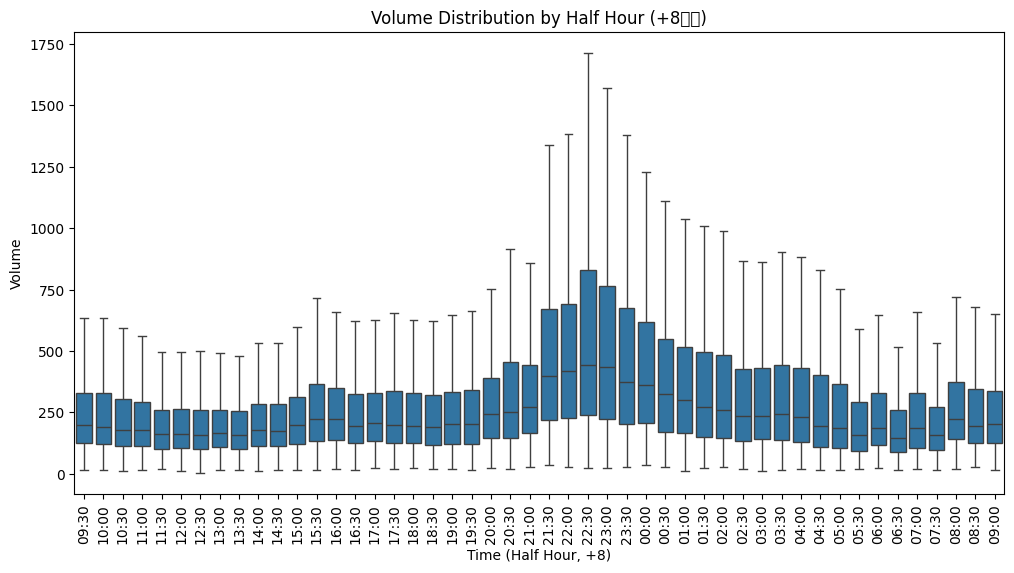

In [38]:
# 提取东八区的小时和分钟，并按半小时分组
data['half_hour'] = data.index.hour.astype(str).str.zfill(2) + ':' + (data.index.minute // 30 * 30).astype(str).str.zfill(2)

plt.figure(figsize=(12, 6))
sns.boxplot(x=data['half_hour'], y=data['volume'], showfliers=False)
plt.xticks(rotation=90)
plt.title('Volume Distribution by Half Hour (+8时区)')
plt.xlabel('Time (Half Hour, +8)')
plt.ylabel('Volume')
plt.show()

c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


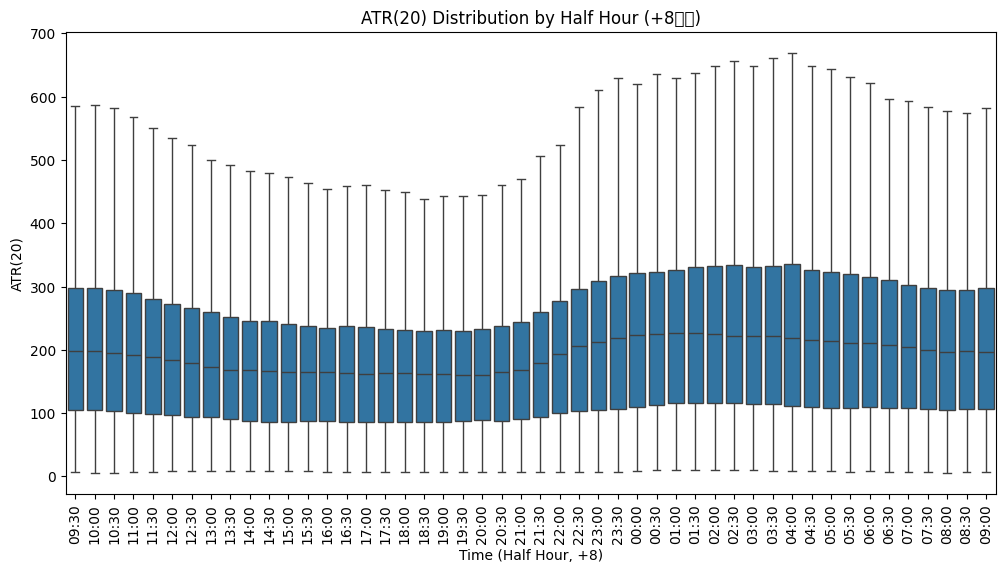

In [32]:
# 半小时分组的ATR分布箱线图
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['half_hour'], y=data['atr_20'], showfliers=False)
plt.xticks(rotation=90)
plt.title('ATR(20) Distribution by Half Hour (+8时区)')
plt.xlabel('Time (Half Hour, +8)')
plt.ylabel('ATR(20)')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\3918034081.py:13: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\hp\AppData\Local\Temp\ipykernel_45368\3918034081.py:13: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


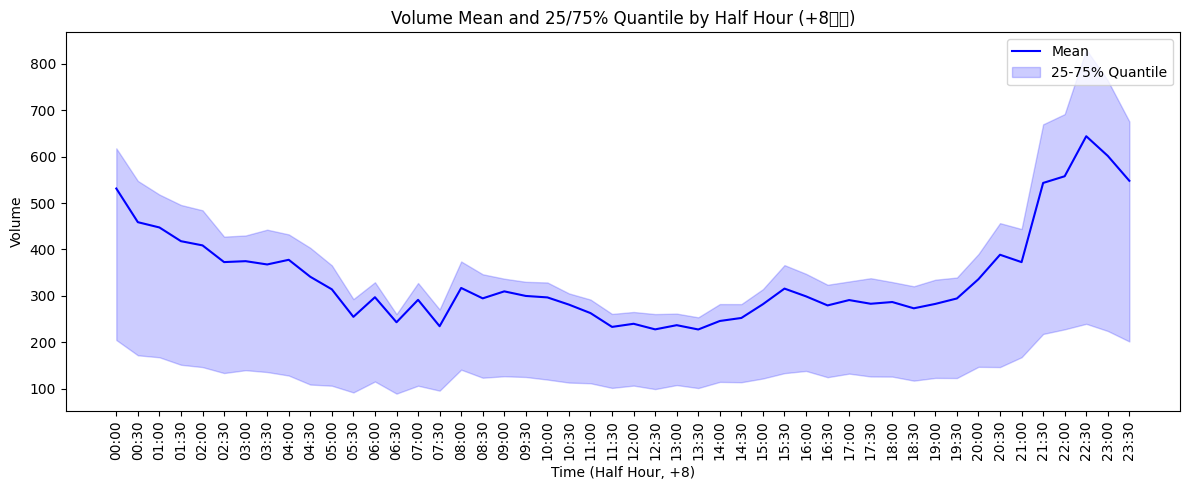

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\3918034081.py:28: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\hp\AppData\Local\Temp\ipykernel_45368\3918034081.py:28: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


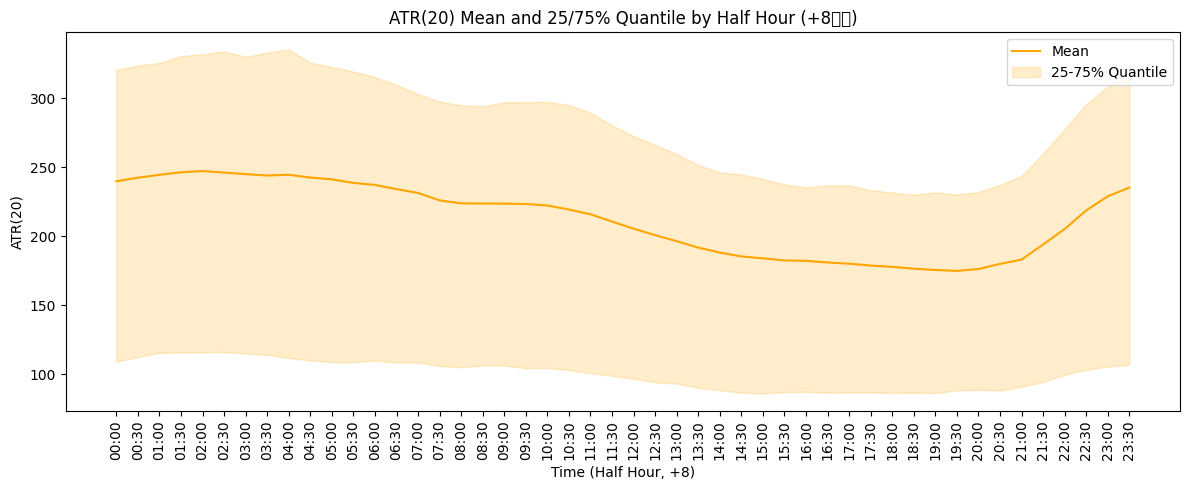

In [39]:
# 统计每半小时的均值、25分位数、75分位数
volume_stats = data.groupby('half_hour')['volume'].agg(['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
volume_stats.columns = ['mean', 'q25', 'q75']

plt.figure(figsize=(12, 5))
plt.plot(volume_stats.index, volume_stats['mean'], label='Mean', color='blue')
plt.fill_between(volume_stats.index, volume_stats['q25'], volume_stats['q75'], color='blue', alpha=0.2, label='25-75% Quantile')
plt.xticks(rotation=90)
plt.title('Volume Mean and 25/75% Quantile by Half Hour (+8时区)')
plt.xlabel('Time (Half Hour, +8)')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()
plt.show()

# ATR同理
atr_stats = data.groupby('half_hour')['atr_20'].agg(['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
atr_stats.columns = ['mean', 'q25', 'q75']

plt.figure(figsize=(12, 5))
plt.plot(atr_stats.index, atr_stats['mean'], label='Mean', color='orange')
plt.fill_between(atr_stats.index, atr_stats['q25'], atr_stats['q75'], color='orange', alpha=0.2, label='25-75% Quantile')
plt.xticks(rotation=90)
plt.title('ATR(20) Mean and 25/75% Quantile by Half Hour (+8时区)')
plt.xlabel('Time (Half Hour, +8)')
plt.ylabel('ATR(20)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\2670437280.py:22: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\hp\AppData\Local\Temp\ipykernel_45368\2670437280.py:22: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hp\anaconda3\envs\fx\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


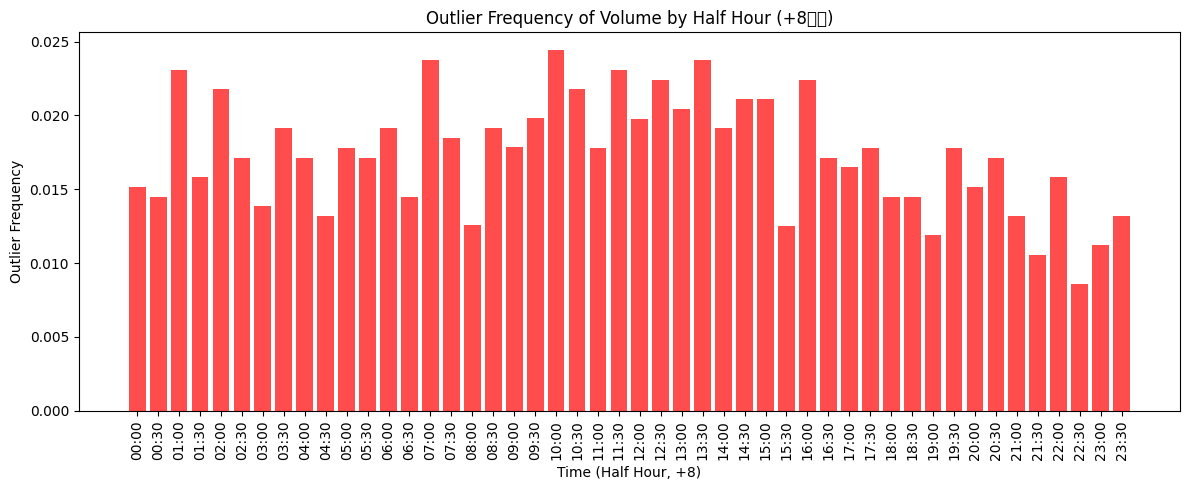

In [41]:
# 计算每个half_hour的极值点数量和比例
outlier_counts = []
for hh, group in data.groupby('half_hour'):
    q1 = group['volume'].quantile(0.1)
    q3 = group['volume'].quantile(0.9)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((group['volume'] < lower) | (group['volume'] > upper))
    count = outliers.sum()
    freq = count / len(group)
    outlier_counts.append({'half_hour': hh, 'outlier_count': count, 'outlier_freq': freq})

outlier_df = pd.DataFrame(outlier_counts).set_index('half_hour')

plt.figure(figsize=(12, 5))
plt.bar(outlier_df.index, outlier_df['outlier_freq'], color='red', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Outlier Frequency of Volume by Half Hour (+8时区)')
plt.xlabel('Time (Half Hour, +8)')
plt.ylabel('Outlier Frequency')
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\2055525931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = data.index.weekday


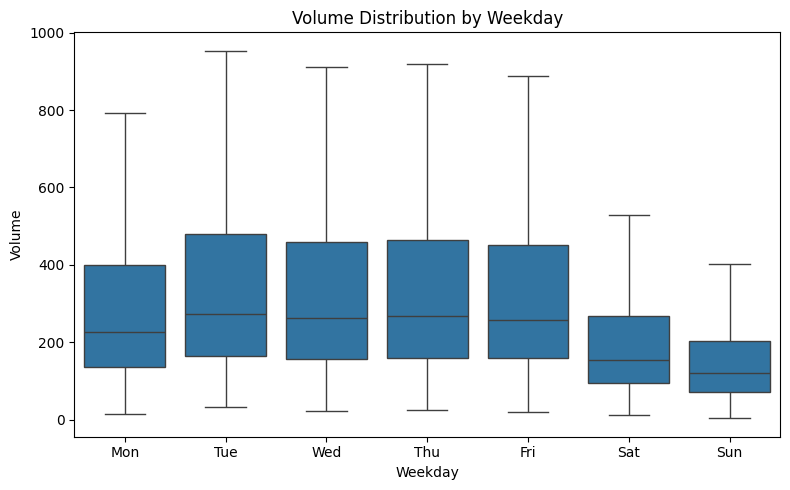

In [42]:
# 统计每周中每日的交易量分布情况

# 添加一列表示星期几（0=Monday, 6=Sunday）
data['weekday'] = data.index.weekday

# 显示箱线图
plt.figure(figsize=(8, 5))
sns.boxplot(x='weekday', y='volume', data=data, showfliers=False)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Volume Distribution by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_45368\178002541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = data.index.weekday


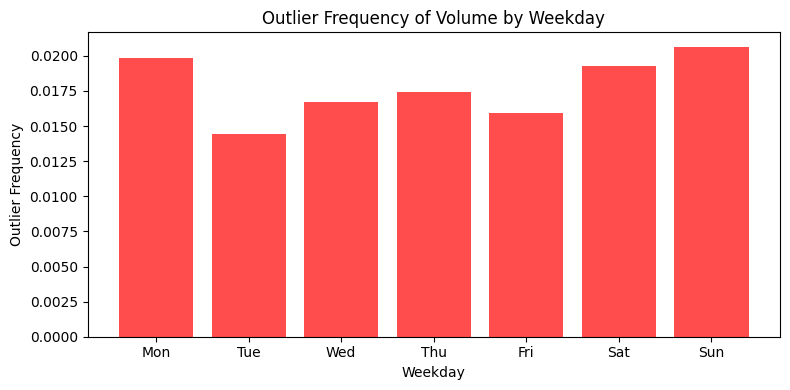

In [44]:
# 统计每周中每日成交量极值点的分布情况

# 先确保有 weekday 列
data['weekday'] = data.index.weekday

# 计算每个weekday的极值点比例
outlier_weekday = []
for wd, group in data.groupby('weekday'):
    q1 = group['volume'].quantile(0.1)
    q3 = group['volume'].quantile(0.9)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((group['volume'] < lower) | (group['volume'] > upper))
    freq = outliers.sum() / len(group)
    outlier_weekday.append({'weekday': wd, 'outlier_freq': freq})

outlier_weekday_df = pd.DataFrame(outlier_weekday).set_index('weekday')

plt.figure(figsize=(8, 4))
plt.bar(outlier_weekday_df.index, outlier_weekday_df['outlier_freq'], color='red', alpha=0.7)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Outlier Frequency of Volume by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Outlier Frequency')
plt.tight_layout()
plt.show()